<a id='start'></a>

# Analyzing Covid-19 Data with PySpark

---

<a id='sec0'></a>

## 0. Introduction

The goal of this project is the loading, preprocessing and exploratory data analysis of SARS-Cov-2 data on a global scale using [PySpark](https://spark.apache.org/docs/latest/api/python/), Apache Spark's Python API. The [dataset](https://github.com/owid/covid-19-data/blob/master/public/data/README.md) was curated and is maintained by [Our World in Data](https://ourworldindata.org/coronavirus) (OWiD). Typically, Spark is utilized when dealing with much larger datasets than the one seen here. In fact, all the tasks performed below could be performed using Pandas, in a somewhat cleaner and more familiar fashion. Nonetheless, the purpose of this notebook is not the analysis itself (especially since Covid-19 data have been extensively analyzed before), but the introduction of the reader to PySpark. In this sense, the dataset is more of a workhorse serving an educational purpose, so Pandas will be used only when absolutely necessary.

<a id='sec1'></a>

## 1. Data Loading & Overview

The present notebook was written in a local environment using Jupyter Lab. As always, in case any of the libraries used in the present notebook is not installed in the environment where the reader intends to run it, please ensure their proper installation beforehand. The following command downloads the dataset from the corresponding GitHub repository.

In [1]:
import warnings
warnings.filterwarnings("ignore")

!pip install pyspark

file = '../input/our-world-in-data-covid19-dataset/owid-covid-data.csv'

     |████████████████████████████████| 281.4 MB 30 kB/s 
     |████████████████████████████████| 198 kB 31.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=ede66e36a6e40ca9a3d6ce73a552588e3d117402922c41e77f61cefd5ba329b6
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


After initializing a PySpark session, the data are transformed into a PySpark DataFrame.

In [2]:
import pyspark
from pyspark.sql import SparkSession, SQLContext

spark = SparkSession.builder.appName("Covid Data Mining").config('spark.sql.debug.maxToStringFields', 2000).getOrCreate()
full_df = spark.read.csv(file, header=True, inferSchema=True)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/10 14:02:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Let's first identify the total number of samples, as well as the number of each sample's features.

In [3]:
print(f"The total number of samples is {full_df.count()}, with each sample corresponding to {len(full_df.columns)} features.")

The total number of samples is 176224, with each sample corresponding to 67 features.


In order to identify each feature, as well as its type, `full_df.dtypes` can be used. Alternatively, they are available as part of the Schema's information via the following:

In [4]:
full_df.printSchema()

root
 |-- iso_code: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- location: string (nullable = true)
 |-- date: string (nullable = true)
 |-- total_cases: double (nullable = true)
 |-- new_cases: double (nullable = true)
 |-- new_cases_smoothed: double (nullable = true)
 |-- total_deaths: double (nullable = true)
 |-- new_deaths: double (nullable = true)
 |-- new_deaths_smoothed: double (nullable = true)
 |-- total_cases_per_million: double (nullable = true)
 |-- new_cases_per_million: double (nullable = true)
 |-- new_cases_smoothed_per_million: double (nullable = true)
 |-- total_deaths_per_million: double (nullable = true)
 |-- new_deaths_per_million: double (nullable = true)
 |-- new_deaths_smoothed_per_million: double (nullable = true)
 |-- reproduction_rate: double (nullable = true)
 |-- icu_patients: double (nullable = true)
 |-- icu_patients_per_million: double (nullable = true)
 |-- hosp_patients: double (nullable = true)
 |-- hosp_patients_per_million

Most of the features are `double` types, i.e. numerical data. However, nominal features are also present:

- `iso_code`: a string corresponding to each country's code.
- `location`: a string corresponding to each location's name.
- `continent`: a string corresponding to the continent where the location belongs.
- `tests_units`: a string corresponding to the units used in each location in order to count the number of tests (more details below).

There's also the `date` feature, the type of which is `string`, however it will be properly transformed into a datetime object in what follows. The following command gives some examples for each of these features.

In [5]:
full_df.select("iso_code","location","continent","date","tests_units").show(5)

+--------+-----------+---------+----------+-----------+
|iso_code|   location|continent|      date|tests_units|
+--------+-----------+---------+----------+-----------+
|     AFG|Afghanistan|     Asia|2020-02-24|       null|
|     AFG|Afghanistan|     Asia|2020-02-25|       null|
|     AFG|Afghanistan|     Asia|2020-02-26|       null|
|     AFG|Afghanistan|     Asia|2020-02-27|       null|
|     AFG|Afghanistan|     Asia|2020-02-28|       null|
+--------+-----------+---------+----------+-----------+
only showing top 5 rows



Note that the `tests_units` column in the above command contains several null values, indicating that many of them may appear in the present dataset. We may import `functions` from `pyspark.sql`, which allows us to perform aggregations (among other things) and count the exact number of `null` values for each feature. The results can be stored in a dictionary, which can then be sorted to present the results in an orderly fashion.

In [6]:
from pyspark.sql import functions as F

miss_vals = full_df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in full_df.columns]).collect()[0].asDict()
miss_vals = dict(sorted(miss_vals.items(), reverse=True, key=lambda item: item[1]))

import pandas as pd

pd.DataFrame.from_records([miss_vals])

,weekly_icu_admissions,weekly_icu_admissions_per_million,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_boosters,total_boosters_per_hundred,...,new_cases_smoothed_per_million,new_cases_smoothed,new_cases_per_million,total_cases_per_million,new_cases,total_cases,population,iso_code,location,date
0,170498,170498,170201,170201,170201,170201,164813,164813,155973,155973,...,9320,8539,7331,7106,6544,6319,1104,0,0,0


Note that in the above Pandas is utilized only for the visualization of the dataframe, so it's not considered as "cheating".

<a id='sec2'></a>

## 2. Data Preprocessing

Taking the above into consideration, the next step is the construction of a filtered version of the full DataFrame, which includes only the January - February 2021 time period. The reason for this is that - up to the day that this notebook is written - the OWiD dataset on Covid-19 is still being expanded. Consequently, any conclusions that may be drawn as part of the present analysis on the full dataset may be altered in the future, when more data become available and a reader attempts to run the notebook as it is. Before doing that, we make sure that the `date` feature is transformed into a `date` type object.

In [7]:
full_df = full_df.withColumn('date',F.to_date(F.unix_timestamp(F.col('date'), 'yyyy-MM-dd').cast("timestamp")))

At this point, `full_df` is filtered in order to keep only the data for the aforementioned two months.

In [8]:
dates = ("2021-01-01", "2021-02-28")
df = full_df.where(F.col('date').between(*dates))

For completeness, we perform for this filtered version the basic tasks that were performed for the full DataFrame:

In [9]:
print(f"The total number of samples is {df.count()}, with each sample corresponding to {len(df.columns)} features.")

miss_vals = df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).collect()[0].asDict()
miss_vals = dict(sorted(miss_vals.items(), reverse=True, key=lambda item: item[1]))

pd.DataFrame.from_records([miss_vals])

The total number of samples is 13515, with each sample corresponding to 67 features.


,weekly_icu_admissions,weekly_icu_admissions_per_million,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,total_boosters,total_boosters_per_hundred,weekly_hosp_admissions,weekly_hosp_admissions_per_million,...,new_cases_smoothed_per_million,new_cases_per_million,total_cases_per_million,new_cases_smoothed,new_cases,total_cases,population,iso_code,location,date
0,13029,13029,13010,13010,13010,13010,12765,12765,12581,12581,...,412,382,378,353,323,319,105,0,0,0


<a id='sec2.1'></a>

### 2.1. Handling Missing Values

<a id='zht2.1'></a>

Even in this filtered version, there's a sizeable number of null values present. Before investigating how to deal with them, it's important that we understand the reason why they're missing. As far as the `continent` feature is concerned, the following command sheds light into the reason why it contains null values.

In [10]:
df.sort("continent").select("iso_code","continent","location").show(5)

+--------+---------+-------------+
|iso_code|continent|     location|
+--------+---------+-------------+
|OWID_SAM|     null|South America|
|OWID_SAM|     null|South America|
|OWID_SAM|     null|South America|
|OWID_SAM|     null|South America|
|OWID_SAM|     null|South America|
+--------+---------+-------------+
only showing top 5 rows



Clearly, OWiD have performed a series of aggregations based on criteria such as income, or general aggregations (for example on the continent level). Since they may prove to be useful later on, there is no reason to discard them. The null values can simply be set equal to the `'OWID'` value, in order to be able to invoke them later on if we need to.

In [11]:
df = df.fillna({'continent':'OWID'})

Another column which corresponds to a nominal feature with missing values is `tests_units`. The distinct values that this feature assumes are:

In [12]:
df.select("tests_units").distinct().show()

+---------------+
|    tests_units|
+---------------+
|           null|
|  people tested|
| samples tested|
|tests performed|
|  units unclear|
+---------------+



In other words, `tests_units` is simply a variable that indicates how each country/location reports on the performed tests. For example, in the case of `people tested`, the reported number of total tests is expected to be lower compared to the same report in the case of `tests performed`, since one person can be tested more than once during the same day. This implies that the missing values are due to some countries/locations not providing the relevant information on how they count the total number of daily tests. Of course, this is not a reason to discard the relevant data, therefore the missing values will be replaced by the string `'no info'`.

In [13]:
df = df.fillna({'tests_units':'no info'})

Moving on to the quantitative features, most missing values are due to the fact that the relevant data were either not available during the studied time period for some locations, or were simply equal to zero. For example, there are 10272 missing values in the `new_vaccinations` column, which are either due to the fact that vaccines were not available in some locations, or due to the fact that these locations reported no vaccinations for specific dates. The best approach in this case is replacing all these values with 0. In the few cases where the missing values are not due to any of these two reasons, but due to wrong reports, bugs, or other reasons, we expect to find it out during their analysis and especially their visualization. In this case, we will be able to re-handle them or discard them completely.

In [14]:
df = df.fillna(0)

The following confirms that there are no missing values left in the dataset.

In [15]:
miss_vals = df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).collect()[0].asDict()
if any(list(miss_vals.values())) != 0:
    print("There are still missing values in the DataFrame.")
else:
    print("All missing values have been taken care of.")

All missing values have been taken care of.


<a id='sec2.2'></a>

### 2.2. Outlier Detection

Having discussed the case of missing values, perhaps it's a good idea to also discuss the case of outliers. Typically, the identification of outliers requires further analysis, such as visualizations, since it is not a trivial matter (in fact, more often than not it's a case of a supervised learning problem on its own). Furthermore, there are several types of outliers, such as global outliers or context-based outliers (i.e. points that are outliers only given a specific condition or context), which means that dealing with outliers in a universal manner is ill-advised. Nonetheless, if one chooses to do so, a systematic way to deal with outliers is based on [interquartile range methods](https://en.wikipedia.org/wiki/Interquartile_range). The interquartile range, $R$, is defined as

$$ R = Q_3 - Q_1 $$

where $Q_i$ is the $i$-th quartile. Every point for which the studied feature has a value higher than $Q_3 + \alpha R$ or lower than $Q_1 - \alpha R$ is classified as an outlier for this specific feature, where $\alpha$ is a scalar that defines a "decision boundary" in units of $R$. This is essentially how [Box plots](https://en.wikipedia.org/wiki/Box_plot) are constructed, where $R$ corresponds to the Box's height and $\alpha R$ is equal to the whiskers' length. One very common choice for $\alpha$ is $\alpha = 1.5$.

Based on these, one can define a function that identifies all outliers with respect to specific features.

In [16]:
def OutlierDetector(dataframe, features, alpha=1.5):
    """
    Args:
        dataframe (pyspark.sql.dataframe.DataFrame):
            the DataFrame hosting the data
        features (string or List):
            List of features (columns) for which we wish to identify outliers.
            If set equal to 'all', outliers are identified with respect to all features.
        alpha (double):
            The parameter that defines the decision boundary (see markdown above)
    """
    feat_types = dict(dataframe.dtypes)
    if features == 'all':
        features = dataframe.columns
        
    outliers_cols = []
    
    for feat in features:
        # We only care for quantitative features
        if feat_types[feat] == 'double':
            Q1, Q3 = dataframe.approxQuantile(feat, [0.25, 0.75], 0)
            R = Q3 - Q1
            lower_bound = Q1 - (R * alpha)
            upper_bound = Q3 + (R * alpha)
            
            # In this way we construct a query, which can be matched to a DataFrame column, thus returning a new
            # column where every point that corresponds to an Outlier has a boolean value set to True
            outliers_cols.append(F.when(~F.col(feat).between(lower_bound, upper_bound), True).alias(feat + '_outlier'))
    
    # Sample points that do not correspond to outliers correspond to a False value for the new column
    outlier_df = dataframe.select(*outliers_cols)
    outlier_df = outlier_df.fillna(False)
    return outlier_df

For example, we can check if any of 5 random DataFrame rows correspond to outliers with respect to the `new_cases` feature:

In [17]:
out_df = OutlierDetector(dataframe=df, features=['new_cases'], alpha=1.5)
out_df.show(5)

+-----------------+
|new_cases_outlier|
+-----------------+
|            false|
|            false|
|            false|
|            false|
|            false|
+-----------------+
only showing top 5 rows



<a id='sec2.3'></a>

#### 2.3. Duplicate Entries

Before proceeding to the exploratory data analysis, the final step of the preprocessing phase is to locate possible duplicate entries and discard the duplicates. When speaking of duplicates we do not actually refer to a whole row, but rather the combined entries of the `date` **and** `location` columns. A duplicate entry on both of these features would imply that the location has provided more than one daily report on a given date. The following command shows that no duplicates exist in the filtered DataFrame, however, even if they did, they could be removed using ```df = df.dropDuplicates(['location','date'])```.

In [18]:
if df.count() != df.select(['location','date']).distinct().count():
    print("There are duplicate entries present in the DataFrame.")
else:
    print("Either there are no duplicate entries present in the DataFrame, or all of them have already been removed).")

Either there are no duplicate entries present in the DataFrame, or all of them have already been removed).


<a id='sec3'></a>

## 3. Exploratory Data Analysis

Before diving into the EDA, we import some libraries and also present some helper functions and commands that will be utilized further down the road for visualizations.

In [19]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import ListedColormap, LinearSegmentedColormap, TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

def CustomCmap(from_rgb,to_rgb):

    # from color r,g,b
    r1,g1,b1 = from_rgb

    # to color r,g,b
    r2,g2,b2 = to_rgb

    cdict = {'red': ((0, r1, r1),
                   (1, r2, r2)),
           'green': ((0, g1, g1),
                    (1, g2, g2)),
           'blue': ((0, b1, b1),
                   (1, b2, b2))}

    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    return cmap

mycmap = CustomCmap([1.0, 1.0, 1.0], [72/255, 99/255, 147/255])
mycmap_r = CustomCmap([72/255, 99/255, 147/255], [1.0, 1.0, 1.0])

mycol = (72/255, 99/255, 147/255)
mycomplcol = (129/255, 143/255, 163/255)
othercol1 = (135/255, 121/255, 215/255)
othercol2 = (57/255, 119/255, 171/255)
othercol3 = (68/255, 81/255, 91/255)
othercol4 = (73/255, 149/255, 139/255)

- **Evolution of top countries with respect to mortality**

Herein, the mortality rate is calculated as the total number of deaths divided by each location's population (another common definition is the total number of deaths by Covid divided by the total number of Covid cases). For this purpose, a column named `mortality` is constructed. Using this column, we identify the top 10 countries in terms of mortality rates, for every day of the studied time interval.

In [20]:
dates_frame = df.select("date").distinct().orderBy('date').collect()
dates_list = [str(dates_frame[x][0]) for x in range(len(dates_frame))]

In [21]:
df_for_mort = df.filter(F.col('population') != 0.0).withColumn("mortality", F.col("total_deaths")/F.col("population"))

for i, this_day in enumerate(dates_list):
    this_day_top_10 = df_for_mort.filter(F.col('date') == this_day).orderBy("mortality", ascending=False).select(["location","mortality"]).take(10)
    if i == 0:
        ct_list = [(this_day_top_10[x][0],this_day_top_10[x][1]) for x in range(10)]
        print("During "+this_day+", the top 10 countries with the highest mortality rate were:")
        for country, instance in ct_list:
            print(f"▶ {country}, with mortality rate {100*instance:.2f}%.")
        new_set = set(ct_list[x][0] for x in range(10))
    elif i == len(dates_list)-1:
        ct_list = [(this_day_top_10[x][0],this_day_top_10[x][1]) for x in range(10)]
        print("During "+this_day+", the top 10 countries with the highest mortality rate were:")
        for country, instance in ct_list:
            print(f"▶ {country}, with mortality rate {100*instance:.2f}%.")
    else:
        new_set = set(this_day_top_10[x][0] for x in range(10))
        if new_set != old_set:
            left_out = old_set-new_set
            new_additions = new_set-old_set
            print("This was the top ten until "+this_day+", when "+", ".join(str(s) for s in new_additions)+" joined the list, replacing "+", ".join(str(s) for s in left_out)+".")
    new_set, old_set = set(), new_set

During 2021-01-01, the top 10 countries with the highest mortality rate were:
▶ Peru, with mortality rate 0.28%.
▶ San Marino, with mortality rate 0.17%.
▶ Belgium, with mortality rate 0.17%.
▶ Slovenia, with mortality rate 0.13%.
▶ Bosnia and Herzegovina, with mortality rate 0.13%.
▶ Italy, with mortality rate 0.12%.
▶ North Macedonia, with mortality rate 0.12%.
▶ Liechtenstein, with mortality rate 0.12%.
▶ Bulgaria, with mortality rate 0.11%.
▶ Czechia, with mortality rate 0.11%.


This was the top ten until 2021-01-08, when United Kingdom joined the list, replacing Bulgaria.


This was the top ten until 2021-01-18, when Gibraltar joined the list, replacing North Macedonia.


This was the top ten until 2021-02-03, when North Macedonia joined the list, replacing Liechtenstein.


This was the top ten until 2021-02-05, when United States joined the list, replacing North Macedonia.


This was the top ten until 2021-02-08, when North Macedonia joined the list, replacing United States.


This was the top ten until 2021-02-09, when Portugal joined the list, replacing North Macedonia.


This was the top ten until 2021-02-23, when Montenegro joined the list, replacing Bosnia and Herzegovina.


During 2021-02-28, the top 10 countries with the highest mortality rate were:
▶ Peru, with mortality rate 0.37%.
▶ Gibraltar, with mortality rate 0.28%.
▶ San Marino, with mortality rate 0.22%.
▶ Belgium, with mortality rate 0.19%.
▶ Czechia, with mortality rate 0.19%.
▶ Slovenia, with mortality rate 0.18%.
▶ United Kingdom, with mortality rate 0.18%.
▶ Italy, with mortality rate 0.16%.
▶ Portugal, with mortality rate 0.16%.
▶ Montenegro, with mortality rate 0.16%.


A better way of approaching this is by developing a series of lollipop charts that depict the evolution of the top 10 countries with respect to the mortality rate. The python code used to extract each lollipop chart image can be found in the [Appendix](#appendix) and all images were merged into a .gif file using Adobe Photoshop. The result can be seen below:

<center> <img src="https://srigas.me/github/covid_mortality_rate.gif" width=420> </center>

The lollipop chart provides the information that the code above provided. In addition to that, it presents the exact changes in ratings between the top 10 countries.

- **Evolution of top countries with respect to total cases per million**

The same procedure can be performed for the number of total cases per million. We choose to normalize the total number of cases in this way in order to be able to compare locations with different populations.

In [22]:
for i, this_day in enumerate(dates_list):
    this_day_top_10 = df.filter(F.col('date') == this_day).orderBy("total_cases_per_million", ascending=False).select(["location","total_cases_per_million"]).take(10)
    if i == 0:
        ct_list = [(this_day_top_10[x][0],this_day_top_10[x][1]) for x in range(10)]
        print("During "+this_day+", the top 10 countries with the highest number of total cases per million were:")
        for country, instance in ct_list:
            print(f"▶ {country}, with {instance} total cases per million.")
        new_set = set(ct_list[x][0] for x in range(10))
    elif i == len(dates_list)-1:
        ct_list = [(this_day_top_10[x][0],this_day_top_10[x][1]) for x in range(10)]
        print("During "+this_day+", the top 10 countries with the highest number of total cases per million were:")
        for country, instance in ct_list:
            print(f"▶ {country}, with {instance} total cases per million.")
    else:
        new_set = set(this_day_top_10[x][0] for x in range(10))
        if new_set != old_set:
            left_out = old_set-new_set
            new_additions = new_set-old_set
            print("This was the top ten until "+this_day+", when "+", ".join(str(s) for s in new_additions)+" joined the list, replacing "+", ".join(str(s) for s in left_out)+".")
    new_set, old_set = set(), new_set

During 2021-01-01, the top 10 countries with the highest number of total cases per million were:
▶ Andorra, with 104933.164 total cases per million.
▶ Montenegro, with 77364.736 total cases per million.
▶ Luxembourg, with 73115.905 total cases per million.
▶ San Marino, with 70097.03 total cases per million.
▶ Czechia, with 68256.644 total cases per million.
▶ Gibraltar, with 65655.516 total cases per million.
▶ United States, with 61189.671 total cases per million.
▶ French Polynesia, with 59907.834 total cases per million.
▶ Slovenia, with 59627.954 total cases per million.
▶ Liechtenstein, with 58686.673 total cases per million.


This was the top ten until 2021-01-07, when Panama joined the list, replacing French Polynesia.


This was the top ten until 2021-01-13, when Slovakia joined the list, replacing Liechtenstein.


This was the top ten until 2021-02-05, when Portugal joined the list, replacing Panama.


This was the top ten until 2021-02-10, when Israel joined the list, replacing Portugal.


During 2021-02-28, the top 10 countries with the highest number of total cases per million were:
▶ Andorra, with 140471.081 total cases per million.
▶ Gibraltar, with 125819.952 total cases per million.
▶ Montenegro, with 120744.971 total cases per million.
▶ Czechia, with 115201.072 total cases per million.
▶ San Marino, with 109261.982 total cases per million.
▶ Slovakia, with 108027.497 total cases per million.
▶ Slovenia, with 91441.236 total cases per million.
▶ Luxembourg, with 86812.83 total cases per million.
▶ United States, with 86351.972 total cases per million.
▶ Israel, with 83500.915 total cases per million.


The corresponding .gif image can be seen below.

<center> <img src="https://srigas.me/github/total_cases_covid_lollipop.gif" width=420> </center>

- **Hospitalized Patients and ICU Admissions**

Moving on, we study the `hosp_patients` and `icu_patients` features by visualizing the corresponding timeseries for the total number of hospitalized and ICU patients on a global scale.

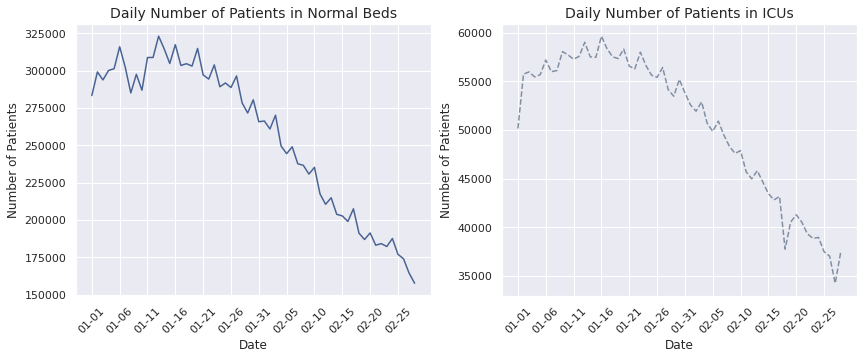

In [23]:
dt_ord = df.orderBy("date", ascending=True).groupBy("date")

hosps = dt_ord.agg(F.sum("hosp_patients")).collect()
hosps = [hosps[i][1] for i in range(len(hosps))]

icus = dt_ord.agg(F.sum("icu_patients")).collect()
icus = [icus[i][1] for i in range(len(icus))]

sns.set(style = "darkgrid")

alt_dts_list = [dt.replace('2021-', '') for dt in dates_list]
tick_marks = np.arange(len(alt_dts_list))

fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(14,5))

for pat, col, style, ax, where in zip([hosps,icus], [mycol, mycomplcol],
                                      ['solid', 'dashed'], [ax1,ax2], ['Normal Beds','ICUs']): 
    ax.plot(alt_dts_list, pat, linestyle=style, color=col)
    ax.set_xlabel("Date")
    ax.set_ylabel("Number of Patients")
    ax.set_title(f"Daily Number of Patients in {where}", fontsize=14)
    ax.set_xticks(tick_marks[::5])
    ax.set_xticklabels(alt_dts_list[::5], rotation=45)
    
plt.show()

matplotlib.rc_file_defaults()

It becomes evident that the overall trend is downwards for both hospital and ICU admissions, since both numbers have declined to almost half their initial value by the end of the two-month period under study. It is worth noting that an upwards trend seems to appear near the end of February in the case of ICU patients. Of course, without further information we can't know if it is the beginning of a monotonically increasing trend, or simply a momentary increase, as the one identified between February 15-20. Finally, notice that both diagrams have a similar behavior, which hints at a correlation between the number of hospital patients and the number of ICU patients (which is probably expected). An important difference is that the absolute value of the number of hospital patients is considerably higher compared to the number of ICU admissions, which is reasonable, since the number of milder cases is higher compared to the number of more severe ones.

- **Geographic Heatmap of Total Cases**

An interesting visualization is the geographic heatmap, which is a 2D representation of countries world-wide which are colored depending on their intensity as far as a specific feature is concerned. Below, we construct the geographic heatmap for the number of total cases on a global scale. A heatmap image is extracted for each day and afterwards all images are merged into a .gif file. The heatmap is constructed using the geopandas library, as seen below. Note that to do this, we must first download a shapefile (.shp) which is the foundation for the construction of the heatmap and can be found [here](https://www.naturalearthdata.com/downloads/10m-cultural-vectors/).

In [24]:
import requests, zipfile
from io import BytesIO

zip_file_url = "https://srigas.me/kaggle/owid-nb-data.zip"

request = requests.get(zip_file_url)
zipDocument = zipfile.ZipFile(BytesIO(request.content))

zipDocument.extractall()

In [25]:
import geopandas as gpd

shapefile = 'countries.shp'
geo_df = gpd.read_file(shapefile)[['ADMIN','ADM0_A3','geometry']]
geo_df.columns = ['location', 'iso_code', 'geometry']
geo_df = geo_df.drop(geo_df.loc[geo_df['location'] == 'Antarctica'].index) # exclude Antarctica

In [26]:
print('Initializing the construction of heatmaps for every day.')

ct = 0
for this_day in dates_list:
    # The conversion of the required columns into a Pandas df is necessary to perform the mapping
    day_df = df.filter(F.col('date') == this_day).select(["iso_code","total_cases"]).toPandas()

    merged_df = pd.merge(left=geo_df, right=day_df, how='left', left_on='iso_code', right_on='iso_code')

    title = f'Total COVID-19 Cases as of {this_day}'
    col = 'total_cases'
    vmin, vmax = merged_df[col].min(), merged_df[col].max()
    cmap = mycmap
    divnorm = TwoSlopeNorm(vcenter=0.08*20365726)

    # Create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(20, 8))

    # Remove the axis
    ax.axis('off')
    merged_df.plot(column=col, ax=ax, edgecolor='1.0', linewidth=1, norm=divnorm, cmap=cmap)

    # Add a title
    ax.set_title(title, fontdict={'fontsize': '25', 'fontweight': '3'})

    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)

    # Empty array for the data range
    sm._A = []

    # Add the colorbar to the figure
    cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
    cbar = fig.colorbar(sm, cax=cbaxes)
    plt.savefig(f'world_map_{this_day}.png', bbox_inches='tight')
    plt.close(fig)
    ct += 1

print(f'Process complete. {ct} heatmap(s) were extracted, ready to be converted into a .gif file.')

Initializing the construction of heatmaps for every day.


Process complete. 59 heatmap(s) were extracted, ready to be converted into a .gif file.


The final .gif can be seen below.

<center> <img src="https://srigas.me/github/covidgif.gif"> </center>

- **Geographic Correlation of Excess Mortality**

Based on the previous visualization it appears that some neighbouring countries are correlated with respect to the total number of cases (for example France and Germany). A reasonable hypothesis is that the same may be true for other features as well, such as the excess mortality.

The excess mortality is a feature for which the reports are weekly and not daily. It is equal to the total number of deaths for a specific week minus the mean number of deaths, based on reports from previous years. While it is not a feature directly connected with Covid, it's expected that during a global pandemic the excess mortality can be mainly attributed to this pandemic.

In order to investigate the correlation between neighbouring countries, we must first develop a list of dates for which reports on excess mortality are available (for all other dates, the entries are equal to zero due to our preprocessing).

In [27]:
exc_dates_list = df.filter(F.col('excess_mortality') != 0.0).select(['date']).distinct().orderBy('date').collect()
exc_dates_list = [str(exc_dates_list[i][0]) for i in range(len(exc_dates_list))]

For brevity, we shall focus our study only on European countries. First, we construct a geographic heatmap of Europe with respect to excess mortality for each date calculated in the previous cell and merge the results into a .gif file, as done previously.

In [28]:
print('Initializing the construction of heatmaps for every day.')

ct = 0
for this_day in exc_dates_list:
    europe_df = df.filter(F.col('date') == this_day).filter(F.col('continent') == 'Europe').filter(F.col('excess_mortality') != 0.0).select(["iso_code","excess_mortality"])
    
    geo_eu = pd.merge(left=geo_df, right=europe_df.toPandas(), how='inner', on='iso_code')

    fig, ax = plt.subplots(1,1)

    col = 'excess_mortality'
    cmap = mycmap

    vmin, vmax = geo_eu[col].min(), geo_eu[col].max()
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)

    ax.axis('off')
    ax.axis([-13, 44, 33, 72])
    geo_eu.plot(column=col, ax=ax, edgecolor='1.0', linewidth=1, norm=None, cmap=cmap)
    ax.set_title(f'Excess Mortality in Europe as of {this_day}', fontdict={'fontsize': '14', 'fontweight': '3'})
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=.2)
    fig.add_axes(cax)
    fig.colorbar(sm, cax=cax)
    plt.savefig(f'europe_{this_day}.png', bbox_inches='tight')
    plt.close(fig)
    ct += 1
    
print(f'Process complete. {ct} heatmap(s) were extracted, ready to be converted into a .gif file.')

Initializing the construction of heatmaps for every day.


Process complete. 9 heatmap(s) were extracted, ready to be converted into a .gif file.


<center> <img src="https://srigas.me/github/europe_excess_mortality.gif"> </center>

Based on this visualization, it's safe to assume that there indeed are neighbouring countries for which the excess mortality values appear to be significantly correlated. Germany and Switzerland are an example of one such pair of countries, as they appear to have highs and lows with respect to excess mortality at the same time.

In order to produce these results with more mathematical rigor, we need to construct a new PySpark DataFrame including all the reports on excess mortality for each European country that has provided reports on **all** of the previously calculated dates. Countries with even 1 missing value will not be taken into consideration, in order to be able to draw conclusions that are as safe as possible, since the volume of the available data is very small with regards to this feature. Then, using this newly created DataFrame, a Pearson correlation matrix can be constructed, thus revealing not only pairs of correlated countries that share the same geographical borders, but also the exact value of this correlation.

In [29]:
european_df = df.filter(F.col('continent') == 'Europe').filter(F.col('excess_mortality') != 0.0)
european_cts = european_df.select(['location']).distinct().collect()
european_cts = [european_cts[i][0] for i in range(len(european_cts)) if european_df.filter(F.col('location') == european_cts[i][0]).count() == len(exc_dates_list)]
print(f'{len(european_cts)} European countries are chosen for this analysis.')

31 European countries are chosen for this analysis.


In [30]:
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window

eu_cts_df = european_df.filter(F.col('location') == european_cts[0]).select(['excess_mortality']).withColumnRenamed("excess_mortality", european_cts[0])
# required for the proper join of the following DataFrames
eu_cts_df = eu_cts_df.withColumn('row_index', row_number().over(Window.partitionBy(F.lit(0)).orderBy(monotonically_increasing_id())))

for country in european_cts[1:]:
    new_ct_df = european_df.filter(F.col('location') == country).select(['excess_mortality']).withColumnRenamed("excess_mortality", country)
    new_ct_df = new_ct_df.withColumn('row_index', row_number().over(Window.partitionBy(F.lit(0)).orderBy(monotonically_increasing_id())))
    
    eu_cts_df = eu_cts_df.join(new_ct_df, on=["row_index"])
    
eu_cts_df = eu_cts_df.drop("row_index")

In [31]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=eu_cts_df.columns, outputCol=vector_col)
df_vector = assembler.transform(eu_cts_df).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col, 'pearson')
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()

The calculated correlation matrix can be seen in the following heatmap, where only values of Pearson correlation that are higher than 0.8 are depicted (since we are looking for neighbouring countries with high correlation). This is why the lower limit of the colorbar is set to 0.8.

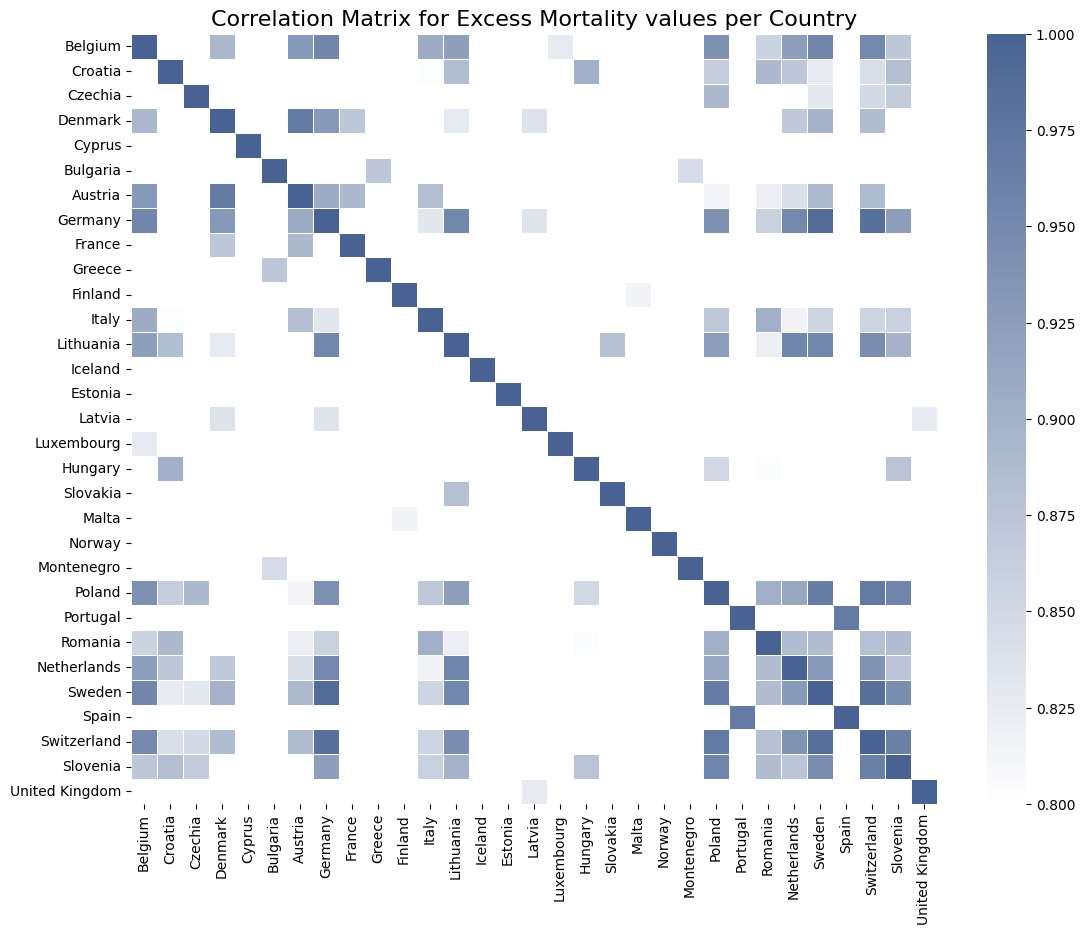

In [32]:
fig, ax = plt.subplots(figsize=(13,10))

sns.heatmap(cor_np, linewidths=.5, ax=ax, vmin=0.8, vmax=1, cmap=mycmap,
            xticklabels=european_cts, yticklabels=european_cts)
ax.set_title('Correlation Matrix for Excess Mortality values per Country', fontsize=16)
plt.show()

As noted before, Switzerland and Germany indeed correspond to a pair of highly correlated neighbouring countries with respect to excess mortality. In fact, it appears that in most cases **only** neighbouring countries (for example Belgium and Germany, or Luxemburg and Netherlands) and second neighbours thereof show high values of correlation, with the value of correlation declining significantly as the neighbour index (i.e. how many countries apart two countries are) increases beyond 2. Some additional examples of correlated pairs can be seen in the following table, along with the corresponding Pearson Correlation.

| | Pearson Correlation for excess mortality (%) |
| :-: | :-: |
| **Germany & Switzerland** | 98.29 |
| **Germany & Belgium** | 95.44 |
| **Lithuania & Poland** | 92.50 |
| **Netherlands & Belgium** | 92.30 |
| **Czechia & Poland** | 89.08 |
| **Greece & Bulgaria** | 86.87 |
| **Italy & Slovenia** | 86.23 |

For a more extensive list of European countries with high correlation that is not limited only to neighbouring countries, one can run the following snippet of code:

```
for i in range(len(european_cts)):
    for j in range(i+1,len(european_cts)):
        corr_val = cor_np[i][j]
        if corr_val > 0.8:
            print(f'{european_cts[i]} and {european_cts[j]} show a correlation of {100*corr_val:.2f}.')
```

- **Reproduction Rate on the Continent Level**

Moving on, we continue the study of the pandemic's features on a geographic viewpoint by grouping the countries together into continents. For this purpose, the DataFrame is split into continent-level DataFrames, in order to be able to draw the geographic heatmaps separately. The studied feature is now the daily reproduction rate, corresponding to the heatmap's intensity, with a common scale in order to be able to compare different continents. As usual, a .gif image is constructed using separate heatmap images for each day in the January-February interval.

Note that all filterings are performed using PySpark, however the joining of the DataFrames is performed using Pandas because [PySpark cannot recognize the column that corresponds to each location's geometry](https://ncar.github.io/PySpark4Climate/tutorials/pyspark-geo-analysis/geopandas-and-spark/), which is required for the construction of the geographic maps.

In [33]:
daily_means = {'AS': [], 'EU' : [], 'NAM' : [], 'SAM' : [], 'OC' : [], 'AF' : []}

print('Initializing the construction of heatmaps for every day.')

ct = 0
for this_day in dates_list:
    asia_df = df.filter(F.col('date') == this_day).filter(F.col('continent') == 'Asia').filter(F.col('reproduction_rate') != 0.0).select(["iso_code","reproduction_rate"])
    europe_df = df.filter(F.col('date') == this_day).filter(F.col('continent') == 'Europe').filter(F.col('reproduction_rate') != 0.0).select(["iso_code","reproduction_rate"])
    namerica_df = df.filter(F.col('date') == this_day).filter((F.col('continent') == 'North America')).filter(F.col('reproduction_rate') != 0.0).select(["iso_code","reproduction_rate"])
    samerica_df = df.filter(F.col('date') == this_day).filter((F.col('continent') == 'South America')).filter(F.col('reproduction_rate') != 0.0).select(["iso_code","reproduction_rate"])
    oceania_df = df.filter(F.col('date') == this_day).filter(F.col('continent') == 'Oceania').filter(F.col('reproduction_rate') != 0.0).select(["iso_code","reproduction_rate"])
    africa_df = df.filter(F.col('date') == this_day).filter(F.col('continent') == 'Africa').filter(F.col('reproduction_rate') != 0.0).select(["iso_code","reproduction_rate"])

    daily_means['AS'].append(asia_df.select(F.mean(F.col('reproduction_rate'))).collect()[0][0])
    daily_means['EU'].append(europe_df.select(F.mean(F.col('reproduction_rate'))).collect()[0][0])
    daily_means['NAM'].append(namerica_df.select(F.mean(F.col('reproduction_rate'))).collect()[0][0])
    daily_means['SAM'].append(samerica_df.select(F.mean(F.col('reproduction_rate'))).collect()[0][0])
    daily_means['OC'].append(oceania_df.select(F.mean(F.col('reproduction_rate'))).collect()[0][0])
    daily_means['AF'].append(africa_df.select(F.mean(F.col('reproduction_rate'))).collect()[0][0])

    geo_as = pd.merge(left=geo_df, right=asia_df.toPandas(), how='inner', on='iso_code')
    geo_eu = pd.merge(left=geo_df, right=europe_df.toPandas(), how='inner', on='iso_code')
    geo_sam = pd.merge(left=geo_df, right=samerica_df.toPandas(), how='inner', on='iso_code')
    geo_nam = pd.merge(left=geo_df, right=namerica_df.toPandas(), how='inner', on='iso_code')
    geo_oc = pd.merge(left=geo_df, right=oceania_df.toPandas(), how='inner', on='iso_code')
    geo_af = pd.merge(left=geo_df, right=africa_df.toPandas(), how='inner', on='iso_code')

    fig, axes = plt.subplots(2,3, figsize=(18,14))

    col = 'reproduction_rate'
    cmap = mycmap

    vmin = min(geo_as[col].min(),geo_eu[col].min(),geo_sam[col].min(),geo_nam[col].min(),geo_oc[col].min(),geo_af[col].min())
    vmax = max(geo_as[col].max(),geo_eu[col].max(),geo_sam[col].max(),geo_nam[col].max(),geo_oc[col].max(),geo_af[col].max())
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)

    for ax, data, cont, dims in zip(axes.flat,
                               [geo_eu, geo_nam, geo_af, geo_as, geo_sam, geo_oc],
                               ['Europe','North America','Africa','Asia','South America','Oceania'],
                               [[-13, 44, 33, 72],[-170, -50, 5, 85],[-20, 55, -38, 40],[25, 145, -10, 60],[-85, -32, -58, 15],[110,160,-45,0]]):
        title = f'{cont}'
        ax.axis('off')
        ax.axis(dims)
        data.plot(column=col, ax=ax, edgecolor='1.0', linewidth=1, norm=None, cmap=cmap)
        ax.set_title(title, fontdict={'fontsize': '18', 'fontweight': '3'})

    clb = fig.colorbar(sm, ax=axes.flat, location='bottom', fraction=0.056)
    clb.ax.set_title(f'COVID-19 Reproduction Rate as of {this_day}', fontsize=22)
    plt.savefig(f'cont_maps_{this_day}.png', bbox_inches='tight')
    plt.close(fig)
    ct += 1

print(f'Process complete. {ct} heatmap(s) were extracted, ready to be converted into a .gif file.')

Initializing the construction of heatmaps for every day.


Process complete. 59 heatmap(s) were extracted, ready to be converted into a .gif file.


<center> <img src="https://srigas.me/github/daily_covid_reproduction.gif"> </center>

On the continental level, it appears that Australia has both the highest and the lowest values for the reproduction rate. Such fluctuations are present in other continents as well, albeit less intense. In general, the reproduction rate appears higher during the last days of February compared to the first days of January, thus indicating an alarming trend of the pandemic. South America is a typical example of this trend, where the reproduction rate appears to stabilize on relatively high values as time passes. On the other hand, there's also the exception of North America (where the fluctuations are uniform for all its countries, thus indicating a high inter-country correlation), where the reproduction rate shows an overall decline during the two studied months.

On the country level, Asian countries tend to follow the pattern of neighbouring-countries correlation that was studied above for the case of excess mortality. In fact, in most cases this correlation can be seen between neighbours of order higher than 1, similar to what was observed in North American countries. Interestingly enough, in Europe, while Portugal and Spain show relatively high reproduction rates compared to other countries in the beginning of January, the exact opposite is true by the end of February. On the one hand, this observation can be attributed to the efficient crisis management by the two countries that gained experience after being struck hard by the pandemic during its early days. On the other hand, it can also be attributed to these countries' efficiency in [providing vaccinations coverage](https://apnews.com/article/coronavirus-pandemic-lifestyle-health-europe-portugal-66ad07ae486a8c396cf8a8f72eb8e30f).

The .gif image above depicts the reproduction rate on the country level as well, apart from the continent level. In order to focus solely on the continent level, we provide below the timeseries for the mean value of the virus' reproduction rate per continent.

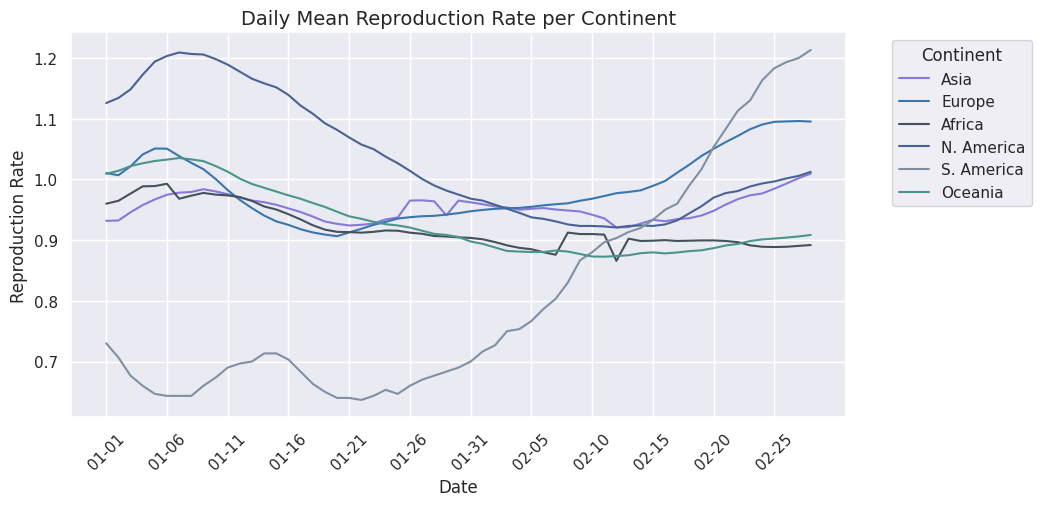

In [34]:
sns.set(style = "darkgrid")

fig, ax = plt.subplots(1, 1, figsize=(10,5))

for key, col, lab in zip(daily_means,
                             [othercol1, othercol2, othercol3, mycol, mycomplcol, othercol4],
                             ['Asia', 'Europe', 'Africa', 'N. America', 'S. America', 'Oceania']): 
    ax.plot(alt_dts_list, daily_means[key], color=col, label = lab)
    
ax.set_xlabel("Date")
ax.set_ylabel("Reproduction Rate")
ax.set_title("Daily Mean Reproduction Rate per Continent", fontsize=14)
tick_marks = np.arange(len(alt_dts_list))
ax.set_xticks(tick_marks[::5])
ax.set_xticklabels(alt_dts_list[::5], rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, title="Continent")
plt.show()

matplotlib.rc_file_defaults()

The trends and fluctuations that were previously observed can be seen in this graph as well. For example, the overall trend towards higher values of reproduction rate is evident in all continents with the exception of North America. Nonetheless, an additional piece of information provided by this new graph is that during the last days of February the mean reproduction rate for the countries in North America has a tendency to increase. The same can be said for the countries of Asia and South America as well. Especially for the countries in South America, the overall increase of the reproduction rate was approximately 60%, indicating that the overall increase may be even higher by the end of March, based on the aforementioned tendency. On the other hand, when it comes to Oceania, Africa and Europe, there is a tendency towards stabilization of the reproduction rate to a constant value. 

Closing this part of the analysis, it's worth noting that the intense fluctuations that were observed for Oceania in the .gif above do not seem to appear in this graph, where the corresponding timeseries is close to being constant, if compared to the other ones. However, upon a closer inspection, it becomes clear that there is no inconsistency: the mean reproduction rate is calculated as an unweighted mean value by diving with the total number of countries, instead of a weighted mean with respect to each country's population. This means that the contribution of Australia is considered equal to that of Papua New Guinea for the calculation of the mean reproduction rate. As a result, the almost constant trend of the timeseries corresponding to Oceania can be attributed to the fact that the trends of Australia and Papua New Guinea as far as reproduction rate is concerned are inverse: whenever the rate is high for Australia, it is low for Papua New Guinea and vice versa.

- **Correlation between different features**

Moving away from the geographic visualizations we proceed to study the correlation between different features on the country level. More specifically, we study the correlation between excess mortality and number of daily tests performed. The columns used for this purpose are `excess_mortality` and `new_tests_smoothed`. The reason why `new_tests_smoothed` is used instead of `new_tests` is because it contains less missing values compared to `new_tests`. Since the analysis is performed on the country level, there is no reason to use normalized features, since the final metric is simply the correlation between different features corresponding to the same country.

It's important to note that not all countries are taken into account, but only these with more than 5 **non zero** entries for the `excess_mortality` feature, for the reasons discussed previously as far as this feature is concerned. Without this filter, a lot of countries seem to show the maximum/minimum value of +1/-1 for the studied correlation, simply because there are very few entries. A typical example is that of Albania, for which the correlation is found equal to +1, simply because it has only 2 entries for the `excess_mortality` feature during the months January-February 2021.

In [35]:
countries_frame = df.select("location").distinct().collect()
exclusion_list = ['Europe', 'World', 'Asia', 'North America', 'South America', 'Africa', 'Oceania', 'Upper middle income']
countries_list = [str(countries_frame[x][0]) for x in range(len(countries_frame)) if str(countries_frame[x][0]) not in exclusion_list]

In [36]:
country_dict = {}
for country in countries_list:
    filtered = df.filter(F.col('location') == country).filter(F.col('excess_mortality') != 0.0)
    if filtered.count() > 5:
        value = filtered.stat.corr("excess_mortality", "new_tests_smoothed")
    else:
        value = np.nan
    if not np.isnan(value):
        country_dict[country] = value

In [37]:
country_dict = dict(sorted(country_dict.items(), reverse=True, key=lambda item: item[1]))
print("As far as the correlation between new tests and excess mortality is concerned:\n")
print("The ten countries with the highest correlation are:")
for i, ct in enumerate(country_dict):
    if i == 10: break
    print(f"{ct}, with correlation equal to {country_dict[ct]:.3f}.")
country_dict = dict(sorted(country_dict.items(), reverse=False, key=lambda item: item[1]))
print("\nThe ten countries with the lowest correlation are:")
for i, ct in enumerate(country_dict):
    if i == 10: break
    print(f"{ct}, with correlation equal to {country_dict[ct]:.3f}.")

As far as the correlation between new tests and excess mortality is concerned:

The ten countries with the highest correlation are:
Spain, with correlation equal to 0.976.
South Africa, with correlation equal to 0.968.
Peru, with correlation equal to 0.962.
Portugal, with correlation equal to 0.960.
Mexico, with correlation equal to 0.921.
Colombia, with correlation equal to 0.916.
United States, with correlation equal to 0.794.
Lithuania, with correlation equal to 0.762.
South Korea, with correlation equal to 0.723.
Ecuador, with correlation equal to 0.670.

The ten countries with the lowest correlation are:
Slovakia, with correlation equal to -0.883.
Denmark, with correlation equal to -0.828.
Romania, with correlation equal to -0.762.
New Zealand, with correlation equal to -0.729.
Switzerland, with correlation equal to -0.715.
Italy, with correlation equal to -0.698.
Sweden, with correlation equal to -0.643.
Luxembourg, with correlation equal to -0.543.
Guatemala, with correlation eq

For the countries where the correlation is positive and close to one, elevated numbers of excess mortality seem to be related to an elevated number of daily tests and vice versa. This might concern countries which, by January or February 2021, had been severely affected by the pandemic and therefore performed a lot of daily tests, in order to be able to restrain the virus outbreak by isolating infected individuals and performing case tracking. [Spain and Portugal](https://pubmed.ncbi.nlm.nih.gov/33334400/) are two examples of such countries.

On the other hand, in countries with the inverse correlation, either elevated numbers of excess mortality were not enough to pressure for more diagnostic tests (for example Romania), or despite low numbers of excess mortality, the daily tests performed were highly elevated for prevention (for example New Zealand or Luxemburg).

Before moving on, it is interesting to also study the correlation between the excess mortality and the course of the vaccination in each country, instead of the daily tests. Note that for this purpose we use the `total_vaccinations` feature instead of the `new_vaccinations` one, since vaccinations are a long-term measure. As a result, their efficiency cannot be imprinted on the number of daily vaccinations. For example, a country in which a high percentage of the population has been vaccinated (for example Israel) is expected to show small numbers of daily vaccinations, without this being an indication of an unvaccinated population.

In [38]:
country_dict = {}
for country in countries_list:
    filtered = df.filter(F.col('location') == country).filter(F.col('excess_mortality') != 0.0)
    if filtered.count() > 5:
        value = filtered.stat.corr("excess_mortality", "total_vaccinations")
    else:
        value = np.nan
    if not np.isnan(value):
        country_dict[country] = value

In [39]:
country_dict = dict(sorted(country_dict.items(), reverse=True, key=lambda item: item[1]))
print("As far as the correlation between excess mortality and the course of the vaccinations is concerned:\n")
print("The ten countries with the highest correlation are:")
for i, ct in enumerate(country_dict):
    if i == 10: break
    print(f"{ct}, with correlation equal to {country_dict[ct]:.3f}.")
country_dict = dict(sorted(country_dict.items(), reverse=False, key=lambda item: item[1]))
print("\nThe ten countries with the lowest correlation are:")
for i, ct in enumerate(country_dict):
    if i == 10: break
    print(f"{ct}, with correlation equal to {country_dict[ct]:.3f}.")

As far as the correlation between excess mortality and the course of the vaccinations is concerned:

The ten countries with the highest correlation are:
Croatia, with correlation equal to 0.937.
Cyprus, with correlation equal to 0.694.
Malta, with correlation equal to 0.667.
Peru, with correlation equal to 0.584.
Ecuador, with correlation equal to 0.410.
Chile, with correlation equal to 0.410.
Finland, with correlation equal to 0.380.
Greece, with correlation equal to 0.246.
Australia, with correlation equal to 0.215.
Bulgaria, with correlation equal to 0.206.

The ten countries with the lowest correlation are:
Germany, with correlation equal to -0.986.
United States, with correlation equal to -0.985.
Switzerland, with correlation equal to -0.955.
Denmark, with correlation equal to -0.952.
Sweden, with correlation equal to -0.945.
Belgium, with correlation equal to -0.925.
Lithuania, with correlation equal to -0.921.
Latvia, with correlation equal to -0.905.
Canada, with correlation eq

In this case, most countries show a negative correlation (and more specifically close to -1), since the increase in total vaccinations is expected to lead to a reduction in excess mortality, as vaccinations have proven to prevent serious infections from Covid. However, there are still countries such as Cyprus or Croatia, where the correlation is positive. There, it's possible that vaccines became available for the general population during the studied time interval and as a result their efficiency on combating the pandemic has not yet been observed on large scales.

- **Covid and general health conditions on the country level**

Another interesting aspect of excess mortality is how it correlates with the general health conditions of a country's population. For this reason, we will first calculate the mean value of the 'female_smokers', 'male_smokers', 'diabetes_prevalence' and 'cardiovasc_death_rate' features, using the data on the last available date of our filtered DataFrame. Then, we will sort all countries with respect to their excess mortality per million, since a normalization is required when comparing different countries (and hence different populations). Finally, we will compare the values of the aforementioned features for the top 5 and the bottom 5 countries with their calculated mean values.

In [40]:
this_day = dates_list[-1]
filtered_df = df.filter(F.col('date') == this_day)

mean_fem_smokers = filtered_df.filter(F.col('female_smokers') != 0.0).select(F.mean(F.col('female_smokers'))).collect()[0][0]
mean_male_smokers = filtered_df.filter(F.col('male_smokers') != 0.0).select(F.mean(F.col('male_smokers'))).collect()[0][0]
mean_diabetes = filtered_df.filter(F.col('diabetes_prevalence') != 0.0).select(F.mean(F.col('diabetes_prevalence'))).collect()[0][0]
mean_card = filtered_df.filter(F.col('cardiovasc_death_rate') != 0.0).select(F.mean(F.col('cardiovasc_death_rate'))).collect()[0][0]

print(f'Based on data up to {this_day}, the mean percentage of female smokers is {mean_fem_smokers:.2f}%, while the corresponding number for male smokers is {mean_male_smokers:.2f}%.')
print(f'In addition, the mean percentage of people suffering from diabetes (aged 20-79) is {mean_diabetes:.2f}%, while the mean number of deaths per 100.000 people due to cardiovascular conditions is {mean_card:.2f}.')

Based on data up to 2021-02-28, the mean percentage of female smokers is 10.40%, while the corresponding number for male smokers is 32.69%.
In addition, the mean percentage of people suffering from diabetes (aged 20-79) is 8.27%, while the mean number of deaths per 100.000 people due to cardiovascular conditions is 263.17.


In [41]:
filtered_df = filtered_df.filter(F.col('diabetes_prevalence') != 0.0).filter(F.col('cardiovasc_death_rate') != 0.0).filter(F.col('female_smokers') != 0.0).filter(F.col('male_smokers') != 0.0)
filtered_df.orderBy("excess_mortality_cumulative_per_million", ascending=False).select(["location", "excess_mortality_cumulative_per_million", "female_smokers", "male_smokers", "diabetes_prevalence", "cardiovasc_death_rate"]).toPandas().head(5)

,location,excess_mortality_cumulative_per_million,female_smokers,male_smokers,diabetes_prevalence,cardiovasc_death_rate
0,Armenia,3613.725554,1.5,52.1,7.11,341.010
1,Mexico,3437.694368,6.9,21.4,13.06,152.783
2,Belarus,3287.984465,10.5,46.1,5.18,443.129
3,Russia,3151.540865,23.4,58.3,6.18,431.297
4,Albania,2854.503445,7.1,51.2,10.08,304.195


The table below depicts the divergence of these characteristics from their mean values for each of the top 5 countries with respect to excess mortality (per million). The red color is used for the entries which are higher than their corresponding mean value.

| | Female Smokers (%) | Male Smokers (%) | Diabetic Population (%) | Cardiovascular-related Deaths per 100.000 (%) |
| :-: | :-: | :-: | :-: | :-: |
| **Armenia** | -85.58 | <font color='red'>59.38</font> | -12.87 | <font color='red'>29.17</font> |
| **Mexico** | -33.65 | -34.54 | <font color='red'>60.05</font> | -42.14 |
| **Belarus** | <font color='red'>0.96</font> | <font color='red'>41.02</font> | -36.52 | <font color='red'>67.82</font> |
| **Russia** | <font color='red'>125</font> | <font color='red'>78.34</font> | -24.26 | <font color='red'>63.34</font> |
| **Albania** | -31.73 | <font color='red'>56.62</font> | <font color='red'>23.53</font> | <font color='red'>15.20</font> |

First and foremost, it's evident that all of the above countries have at least one of the mentioned features assume a value higher than it's mean. With the exception of Mexico, the countries with the highest excess mortality are characterized by numbers of cardiovascular related deaths that are higher compared to their mean value. The same countries also show significantly increased percentages of male smokers, which is definitely correlated to the number of deaths due to cardiovascular causes. The percentages of female smokers do not show the same tendency, excluding Russia, where the percentage of the divergence from the mean is higher than 100%. Finally, as far as the diabetic population is concerned, Mexico (for which we observed lower numbers with respect to the other features, compared to their mean values) has a value higher than the mean value by 60%.

In [42]:
filtered_df.orderBy("excess_mortality_cumulative_per_million", ascending=True).select(["location", "excess_mortality_cumulative_per_million", "female_smokers", "male_smokers", "diabetes_prevalence", "cardiovasc_death_rate"]).toPandas().head(5)

,location,excess_mortality_cumulative_per_million,female_smokers,male_smokers,diabetes_prevalence,cardiovasc_death_rate
0,Seychelles,-1678.293398,7.1,35.7,10.55,242.648
1,Barbados,-832.093651,1.9,14.5,13.57,170.050
2,Uruguay,-682.380568,14.0,19.9,6.93,160.708
3,Mongolia,-605.836333,5.5,46.5,4.82,460.043
4,Malaysia,-465.227889,1.0,42.4,16.74,260.942


Moving on to the bottom 5 countries as far as excess mortality is concerned, it is worth noting that the negative values in these cases is not because of a bug or missing data. On the contrary, it is because the reported numbers of deaths from these countries during the studied period were lower compared to their expected number, based on previous years' reports. A table similar to the one shown for the top 5 can be seen below.

| | Female Smokers (%) | Male Smokers (%) | Diabetic Population (%) | Cardiovascular-related Deaths per 100.000 (%) |
| :-: | :-: | :-: | :-: | :-: |
| **Seychelles** | -31.73 | <font color='red'>9.21</font> | <font color='red'>29.29</font> | -8.11 |
| **Barbados** | -81.73 | -55.64 | <font color='red'>66.30</font> | -35.60 |
| **Uruguay** | <font color='red'>34.62</font> | -39.13 | -15.07 | -39.14 |
| **Mongolia** | -47.12 | <font color='red'>42.25</font> | -40.93 | <font color='red'>74.21</font> |
| **Malaysia** | -90.38 | <font color='red'>29.70</font> | <font color='red'>105.15</font> | -1.18 |

In this case as well, all countries have at least 1 studied feature with value higher than the corresponding mean. Nonetheless, the most important issue that was present for the top 5 countries, i.e. the elevated numbers of death by cardiovascular causes, does not seem to appear in this case as well, with the exception of Mongolia. When it comes to the percentage of smokers, it appears significantly reduced for both sexes. In contrast to what was observed for the top 5 countries, the countries with the lowest excess mortality tend to have increased diabetic populations.

Based on these, one could conclude that the excess mortality due to Covid can be connected to high percentages of smokers in the general population, as well as cardiovascular diseases. Similar conclusions cannot be drawn for the case of diabetes, which may be uncorrelated with deaths due to Covid. Of course, more extensive studies need to be performed in order to draw such conclusions safely, as well as more tests on target groups.

- **k-Means Clustering**

Moving on to the final part of this EDA, we incorporate unsupervised learning methods, and more specifically k-Means clustering, in order to draw some additional information from our data. This is our final study on excess mortality and we intend to cluster countries together with respect to it, as well as the total number of cases - both normalized. This clustering will be performed on two different dates: the first and the final date present in our filtered DataFrame, in order to be able to see the evolution of the initial state. As previously done, we will only take into account countries with no missing values (i.e. zeroes) on excess mortality.

As is always the case with k-Means clustering, the question that needs to be answered is "what is the optimal value of k?". While we could use methods such as the Elbow method to determine a good value for k, the purpose of this notebook is not an extensive study of clustering, but rather the presentation of a few basic methods for EDA using PySpark instead of widely used libraries such as Pandas or scikit-learn, for relatively small datasets. For this reason, we will simply create a scatterplot of the data and determine an optimal value for k through the visualization.

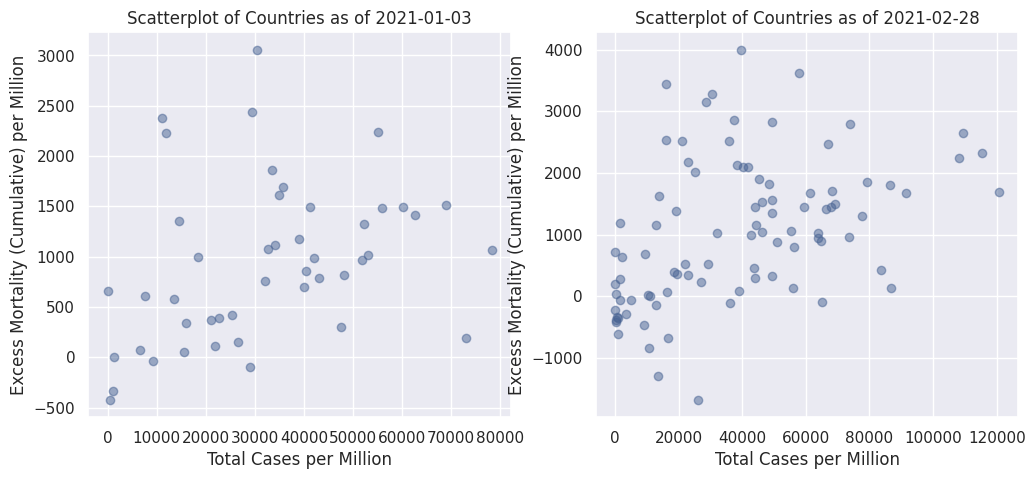

In [43]:
sns.set(style = "darkgrid")
    
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(12,5))

for idx, (ax,this_day) in enumerate(zip([ax1,ax2],[exc_dates_list[0],exc_dates_list[-1]])):
    
    eff_df = df.filter(F.col('excess_mortality_cumulative_per_million') != 0.0).filter(F.col('date') == this_day).select(['total_cases_per_million','excess_mortality_cumulative_per_million','location'])

    pdf = eff_df.select(['total_cases_per_million','excess_mortality_cumulative_per_million']).toPandas()

    points = ax.scatter(pdf.total_cases_per_million, pdf.excess_mortality_cumulative_per_million,
                                  color=mycol, alpha=0.5)

    ax.set_title(f'Scatterplot of Countries as of {this_day}')
    ax.set_xlabel('Total Cases per Million')
    ax.set_ylabel('Excess Mortality (Cumulative) per Million')

plt.show()

matplotlib.rc_file_defaults()

Even through this preliminary visualization we can extract a very important conclusion as far as the data themselves are concerned: the number of countries which report on excess mortality has increased by the end of February, since the second scatterplot includes more points.

As far as the choice of k is concerned, i.e. the number of clusters to be taken into account, a reasonable hypothesis for the first date is k = 2: one cluster that includes the countries with fewer covid cases per million and one that includes the countries with more covid cases per million, since - with the exception of some outliers - it seems that the excess mortality is proportional to the number of total cases. On the other hand, things are somewhat more complex for the second date. We will be choosing k = 3 for this case, expecting to see the four countries with a very high number of cases (see the second scatterplot) in the same cluster.

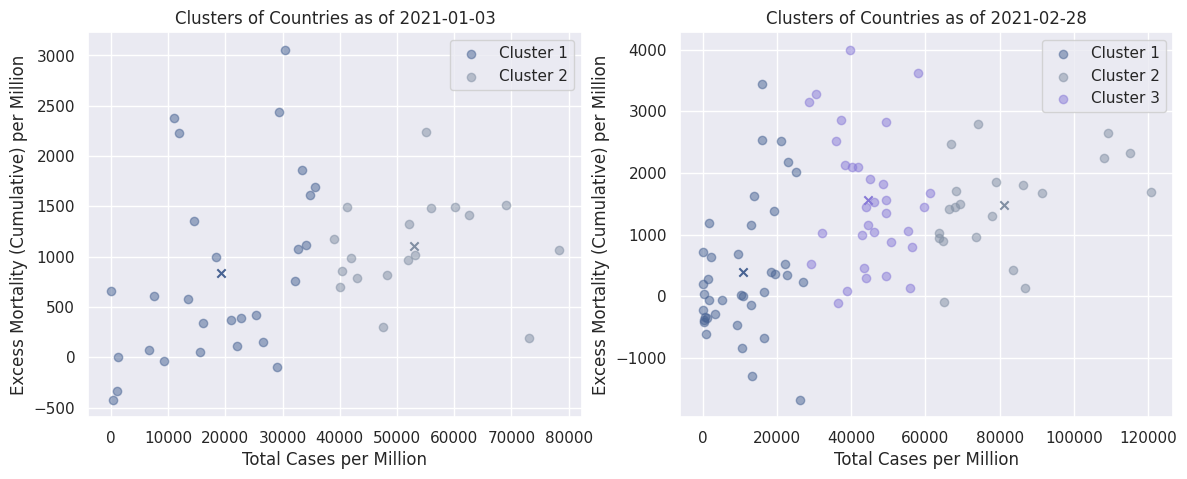

In [44]:
from pyspark.ml.clustering import KMeans

sns.set(style = "darkgrid")

numclusters = [2,3]
colors = [mycol, mycomplcol, othercol1, othercol2, othercol3, othercol4]
    
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(14,5))

for idx, (ax,this_day) in enumerate(zip([ax1,ax2],[exc_dates_list[0],exc_dates_list[-1]])):
    
    eff_df = df.filter(F.col('excess_mortality_cumulative_per_million') != 0.0).filter(F.col('date') == this_day).filter(F.col('date') == this_day).select(['total_cases_per_million','excess_mortality_cumulative_per_million','location'])

    vectorAssembler = VectorAssembler(inputCols = ['total_cases_per_million','excess_mortality_cumulative_per_million'], outputCol = "features")
    feat_df = vectorAssembler.transform(eff_df)
    feat_df = feat_df.select(['features','location'])

    kmeans = KMeans().setK(numclusters[idx]).setSeed(1).setFeaturesCol("features").setPredictionCol("cluster")
    model = kmeans.fit(feat_df)
    transformed = model.transform(feat_df)
    centroids = model.clusterCenters()

    transformed = transformed.join(eff_df, 'location')
    
    clusters, centers, images = {}, {}, {}

    for i in range(numclusters[idx]):

        clusters[i] = transformed.filter(F.col('cluster')==i).select(['location','cluster','total_cases_per_million',
                                                              'excess_mortality_cumulative_per_million']).toPandas().set_index('location')

        images[i] = ax.scatter(clusters[i].total_cases_per_million, clusters[i].excess_mortality_cumulative_per_million,
                                  color=colors[i], alpha=0.5)
        centers[i] = ax.scatter(centroids[i][0], centroids[i][1], color=colors[i], marker='x')

    clusttuple = (images[i] for i in range(numclusters[idx]))
    clustnames = ('Cluster '+str(i+1) for i in range(numclusters[idx]))

    ax.legend(clusttuple, clustnames, loc='best')

    ax.set_title(f'Clusters of Countries as of {this_day}')
    ax.set_xlabel('Total Cases per Million')
    ax.set_ylabel('Excess Mortality (Cumulative) per Million')

plt.show()

matplotlib.rc_file_defaults()

In all cases, different clusters are shown with different colors, with each cluster's centroid depicted with an `X`. As far as the first date (early January) is concerned, it is indeed observed that all countries are split into the two clusters in a way that is expected from the initial visualization. As far as the second date (late February) is concerned, it appears that the 4 countries with more than 100.000 total cases per million (> 10%) indeed belong into the same cluster. All of the countries in this cluster are:

In [45]:
print(*clusters[2].index, sep=', ')

Albania, Armenia, Austria, Belarus, Bosnia and Herzegovina, Brazil, Bulgaria, Chile, Colombia, Croatia, Cyprus, Denmark, Estonia, France, Germany, Hungary, Ireland, Italy, Kosovo, Latvia, Lebanon, Malta, Moldova, Monaco, North Macedonia, Peru, Poland, Qatar, Romania, Russia, Ukraine, United Kingdom


As far as the other two clusters are concerned, it appears that the clustering is based solely on the horizontal axis, i.e. the total number of cases per million. In the cluster with the centroid at ~53000 cases per million, 30 out of 39 countries are European countries. On the other hand, in the cluster with the centroid at ~13000 cases per million, there are countries from all over the world. Some of them are European, but under no circumstances do they correspond to the majority, as was the case in the other cluster.

Closing our investigation on clustering and the project itself, we perform the same steps in order to cluster countries with respect to the virus' reproduction rate and the countries' human development index.

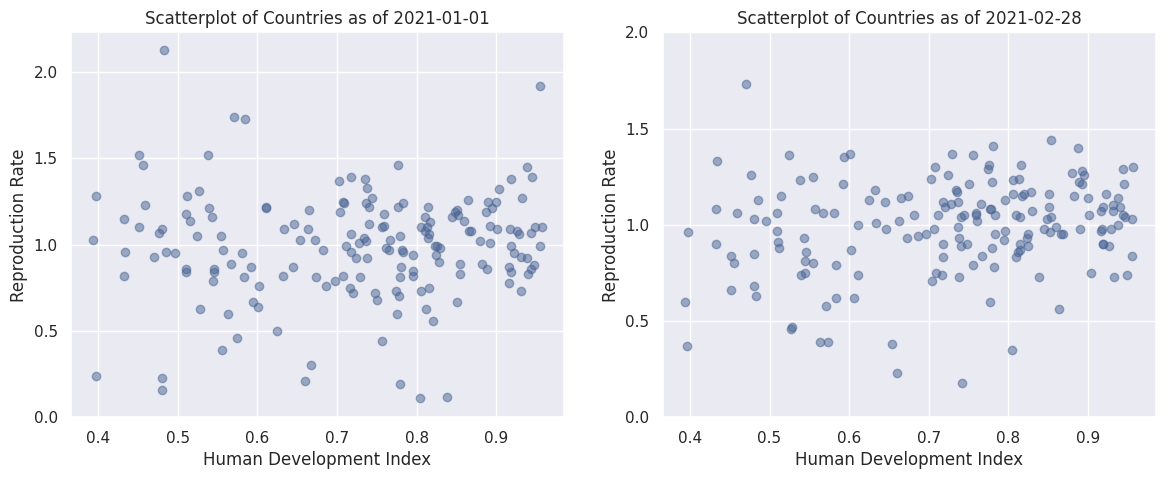

In [46]:
sns.set(style = "darkgrid")
    
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(14,5))

for idx, (ax,this_day) in enumerate(zip([ax1,ax2],[dates_list[0],dates_list[-1]])):
    
    eff_df = df.filter(F.col('human_development_index') != 0.0).filter(F.col('reproduction_rate') != 0.0).filter(F.col('date') == this_day).select(['human_development_index','reproduction_rate','location'])

    pdf = eff_df.select(['human_development_index','reproduction_rate']).toPandas()

    points = ax.scatter(pdf.human_development_index, pdf.reproduction_rate, color=mycol, alpha=0.5)

    ax.set_title(f'Scatterplot of Countries as of {this_day}')
    ax.set_yticks([0.0,0.5,1.0,1.5,2.0])
    ax.set_xlabel('Human Development Index')
    ax.set_ylabel('Reproduction Rate')

plt.show()

matplotlib.rc_file_defaults()

In this case the number of studied countries seems to be constant in the two cases, unlike what we saw with excess mortality. Furthermore, especially in the final date, there seems to be a homogeneity as far as the reproduction rate is concerned. Before we move on with the clustering, we provide a .gif image (see [Appendix](#appendix) for the code) where the time evolution of the scatterplots is shown for all dates in our filtered DataFrame.

<center> <img src="https://srigas.me/github/covid_scatterplots.gif" width=420> </center>

As expected, all changes happen only along the vertical axis, since the human development index of a country is not expected to change during such a short period of time. The countries seem to perform an overall oscillatory motion. In addition, during the first days of January there is a sizeable number of countries with a reproduction rate higher than 1.5, however from a point forward the oscillatory motion seems to be limited in the [0.5,1.5] window, in terms of reproduction rate.

Moving on to the clustering for the first and the final day of the two-month period, k = 3 is chosen for both cases now, since tests performed using different numbers of k did not result into qualitatively interesting results.

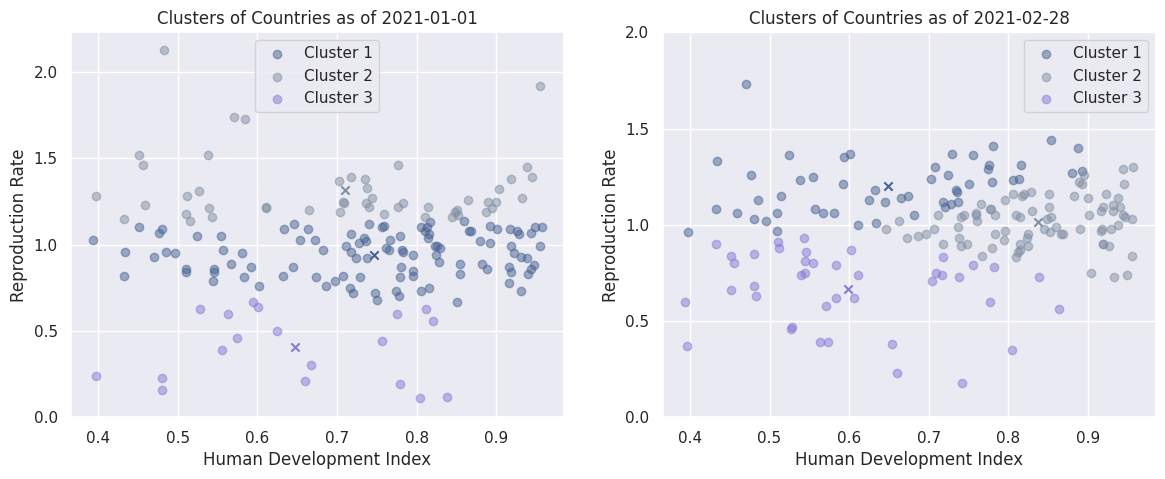

In [47]:
sns.set(style = "darkgrid")

numclusters = [3,3]
colors = [mycol, mycomplcol, othercol1, othercol2, othercol3, othercol4]
    
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(14,5))

for idx, (ax,this_day) in enumerate(zip([ax1,ax2],[dates_list[0],dates_list[-1]])):
    
    eff_df = df.filter(F.col('human_development_index') != 0.0).filter(F.col('reproduction_rate') != 0.0).filter(F.col('date') == this_day).select(['human_development_index','reproduction_rate','location'])

    vectorAssembler = VectorAssembler(inputCols = ['human_development_index','reproduction_rate'], outputCol = "features")
    feat_df = vectorAssembler.transform(eff_df)
    feat_df = feat_df.select(['features','location'])

    kmeans = KMeans().setK(numclusters[idx]).setSeed(1).setFeaturesCol("features").setPredictionCol("cluster")
    model = kmeans.fit(feat_df)
    transformed = model.transform(feat_df)
    centroids = model.clusterCenters()

    transformed = transformed.join(eff_df, 'location')
    
    clusters, centers, images = {}, {}, {}

    for i in range(numclusters[idx]):

        clusters[i] = transformed.filter(F.col('cluster')==i).select(['location','cluster','reproduction_rate',
                                                              'human_development_index']).toPandas().set_index('location')

        images[i] = ax.scatter(clusters[i].human_development_index, clusters[i].reproduction_rate, color=colors[i], alpha=0.5)
        centers[i] = ax.scatter(centroids[i][0], centroids[i][1], color=colors[i], marker='x')

    clusttuple = (images[i] for i in range(numclusters[idx]))
    clustnames = ('Cluster '+str(i+1) for i in range(numclusters[idx]))

    ax.legend(clusttuple, clustnames, loc='best')

    ax.set_title(f'Clusters of Countries as of {this_day}')
    ax.set_yticks([0.0,0.5,1.0,1.5,2.0])
    ax.set_xlabel('Human Development Index')
    ax.set_ylabel('Reproduction Rate')

plt.show()

matplotlib.rc_file_defaults()

It's obvious that the k-Means clustering is performed with respect to the values of the vertical axis (reproduction rate). In both cases, one of the three clusters includes countries with a relatively small reproduction rate (less than 0.5), while the other two seem to split the countries using R = 1.0 as the decision boundary, as far as the reproduction rate is concerned.

As previously stated, this clustering analysis needs to be more carefully performed, perhaps using clustering algorithms with a different principles (for example density-based methods, such as DBSCAN). Unfortunately, PySpark does not yet include such implementations, therefore this task would require the use of scikit-learn in collaboration with Pandas.

<a id='appendix'></a>

## Appendix: Additional Code

Below you can find the code used in order to extract the lollipop charts, as well as the scatterplots that were afterwards transformed into .gif files using Adobe Photoshop.

#### Mortality Rate


```
sns.set(style = "darkgrid")
for this_day in dates_list:
    this_day_top_10 = df_for_mort.filter(F.col('date') == this_day).orderBy("mortality", ascending=False).select(["location","mortality"]).toPandas()

    (markers, stemlines, baseline) = plt.stem(this_day_top_10[0:10]['mortality'])
    plt.setp(markers, color=mycol)
    plt.setp(stemlines, color=mycol)
    plt.setp(baseline, visible=False)
    
    plt.xticks(range(10), this_day_top_10[0:10]['location'], rotation=45)
    plt.title(f'COVID-19 Mortality Rate as of {this_day}', fontsize=14)
    plt.savefig(f'lollipop_chart_cases_{this_day}.png', bbox_inches='tight')
    plt.close()
    
matplotlib.rc_file_defaults()
```

#### Total Cases per Million


```
sns.set(style = "darkgrid")
for this_day in dates_list:
    this_day_top_10 = df.filter(F.col('date') == this_day).orderBy("total_cases_per_million", ascending=False).select(["location","total_cases_per_million"]).toPandas()

    (markers, stemlines, baseline) = plt.stem(this_day_top_10[0:10]['total_cases_per_million'])
    plt.setp(markers, color=mycol)
    plt.setp(stemlines, color=mycol)
    plt.setp(baseline, visible=False)

    plt.xticks(range(10), this_day_top_10[0:10]['location'], rotation=45)
    plt.title(f'Total COVID-19 cases per million as of {this_day}', fontsize=14)
    plt.savefig(f'lollipop_chart_cases_{this_day}.png', bbox_inches='tight')
    plt.close()
    
matplotlib.rc_file_defaults()
```

#### Total Deaths per Million

```
sns.set(style = "darkgrid")
for this_day in dates_list:
    this_day_top_10 = df.filter(F.col('date') == this_day).orderBy("total_deaths_per_million", ascending=False).select(["location","total_deaths_per_million"]).toPandas()

    (markers, stemlines, baseline) = plt.stem(this_day_top_10[0:10]['total_deaths_per_million'])
    plt.setp(markers, color=mycol)
    plt.setp(stemlines, color=mycol)
    plt.setp(baseline, visible=False)

    plt.xticks(range(10), this_day_top_10[0:10]['location'], rotation=45)
    plt.title(f'Total COVID-19 deaths per million as of {this_day}', fontsize=14)
    plt.savefig(f'lollipop_chart_deaths_{this_day}.png', bbox_inches='tight')
    plt.close()
    
matplotlib.rc_file_defaults()
```

#### Human Development Index vs Reproduction Rate

```
sns.set(style = "darkgrid")

for this_day in dates_list:

    fig, ax = plt.subplots(1, 1)
    
    eff_df = df.filter(F.col('human_development_index') != 0.0).filter(F.col('reproduction_rate') != 0.0).filter(F.col('date') == this_day).select(['human_development_index','reproduction_rate','location'])
    pdf = eff_df.select(['human_development_index','reproduction_rate']).toPandas()
    points = ax.scatter(pdf.human_development_index, pdf.reproduction_rate, color=mycol, alpha=0.5)

    ax.set_title(f'Scatterplot of Countries as of {this_day}')
    ax.set_yticks([0.0,0.5,1.0,1.5,2.0])
    ax.set_xlabel('Human Development Index')
    ax.set_ylabel('Reproduction Rate')
    
    plt.savefig(f'hdi_{this_day}.png', bbox_inches='tight')
    plt.close(fig)

matplotlib.rc_file_defaults()
```